# Load Packages

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('classic')
plt.style.use('genstyle')
import numpy as np
from numpy import sqrt as sqrt
from numpy import pi as pi

# make qutip available in the rest of the notebook
from qutip import *

from scipy.constants import k, h, mu_0, e
from scipy.special import ellipk

import scipy.optimize as spopt

phi_0 = h/2/e # For superconductor

pi = np.pi

from numpy.fft import rfft, ifft, fft, irfft


import qubit_system as qs
import csv
import warnings

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import MaxNLocator

warnings.filterwarnings('ignore')


In [2]:
def fit_skewed_lorentzian(f_data,y_data, inverted=False, plot=False):
    amplitude_sqr = y_data
    A1a = np.minimum(amplitude_sqr[0],amplitude_sqr[-1])
    if inverted:
        A3a = -np.max(amplitude_sqr)
        fra = f_data[np.argmin(amplitude_sqr)]
        def fitfunc(x,A1, A2, A3, A4, fr, Ql):
            return A1-A2*(x-fr)-(A3+A4*(x-fr))/(1.+4.*Ql**2*((x-fr)/fr)**2)
    else:
        A3a = np.max(amplitude_sqr)
        fra = f_data[np.argmax(amplitude_sqr)]
        def fitfunc(x,A1, A2, A3, A4, fr, Ql):
            return A1+A2*(x-fr)+(A3+A4*(x-fr))/(1.+4.*Ql**2*((x-fr)/fr)**2)
    def residuals(p,x,y):
        A2, A4, Ql = p
        err = y - fitfunc(x, A1a, A2, A3a, A4, fra, Ql)
        return err
    p0 = [0., 0., 5e2]
    p_final = spopt.leastsq(residuals,p0,args=(np.array(f_data),np.array(amplitude_sqr)))
    A2a, A4a, Qla = p_final[0]

    def residuals2(p,x,y):
        A1, A2, A3, A4, fr, Ql = p
        err = y - fitfunc(x, A1, A2, A3, A4, fr, Ql)
        return err/y

        
    p0 = [A1a, A2a , A3a, A4a, fra, Qla]
    #p_final = spopt.leastsq(residuals2,p0,args=(np.array(f_data),np.array(amplitude_sqr)))
    try:
        popt, pcov = spopt.curve_fit(fitfunc, np.array(f_data), np.array(amplitude_sqr),p0=p0)
    #A1, A2, A3, A4, fr, Ql = p_final[0]
    #print(p_final[0][5])
        if pcov is not None:
            df_error = np.sqrt(pcov[4][4])
            dQl_error = np.sqrt(pcov[5][5])
        else:
            df_error = np.inf
            dQl_error = np.inf
        if plot:
            fig, ax = plt.subplots()
            ax.plot(f_data,amplitude_sqr,label='raw data')
            ax.plot(f_data, fitfunc(f_data, *popt), label=r'fq={:.2f}'.format(popt[4]*1e-9))
            ax.legend()
    #return p_final[0]
    except:
        popt = p0
        df_error = np.inf
        dQl_error = np.inf
    return popt, [df_error,dQl_error, np.sum(np.abs(residuals2(popt, np.array(f_data), np.array(amplitude_sqr))))]

In [3]:
system1 = qs.qubit_cav_sys(fc=6, Ej=80, kappa=3e-3)
N = system1.N
tlist = np.linspace(0, 1500, 3240)
psi0 = tensor(basis(N, 1), basis(2,0))

9.244771528621953


In [4]:
gammas = np.linspace(1e-2, 1, 11)
nth_as = np.linspace(0, 1, 11)
nth_cs = np.linspace(0, 1, 11)

# Qubit as Two-level System

In [8]:
2*pi/0.005

1256.6370614359173

In [5]:
fc = 7            # cavity frequency
fa = 8            # atom frequency
g  = 0.1           # coupling strength
kappa = 0.005       # cavity dissipation rate
gamma = 0.05        # atom dissipation rate
N = 30              # number of cavity fock states
n_th_a = 0        # avg number of thermal bath excitation

# operators
a  = tensor(destroy(N), qeye(2))
sm = tensor(qeye(N), destroy(2))
sx = tensor(qeye(N), sigmax())


# Hamiltonian
H = fc * a.dag() * a + fa * sm.dag() * sm + g * (a.dag()*sm + a*sm.dag())
H_1 = fc * a.dag() * a + fa * sm.dag() * sm

c_ops = []
#
# cavity relaxation
rate = kappa * (1 + n_th_a)
if rate > 0.0:
    c_ops.append(sqrt(rate) * a)
#
# cavity excitation, if temperature > 0
rate = kappa * n_th_a
if rate > 0.0:
    c_ops.append(sqrt(rate) * a.dag())
#
# qubit relaxation
rate = gamma * (1+n_th_a)
if rate > 0.0:
    c_ops.append(sqrt(rate) * sm)
    
rate = gamma * n_th_a
if rate > 0.0:
    c_ops.append(sqrt(rate) * sm.dag())

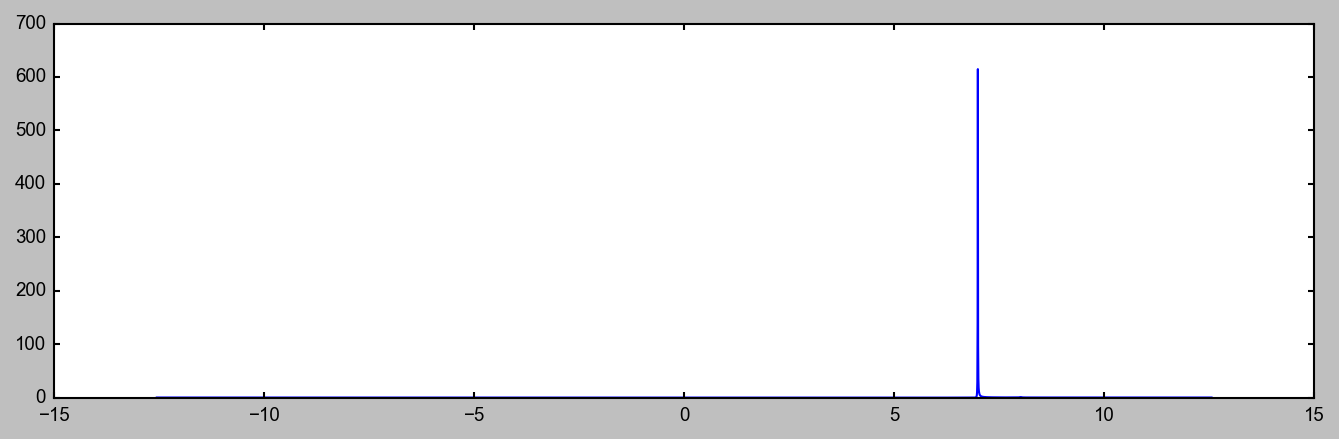

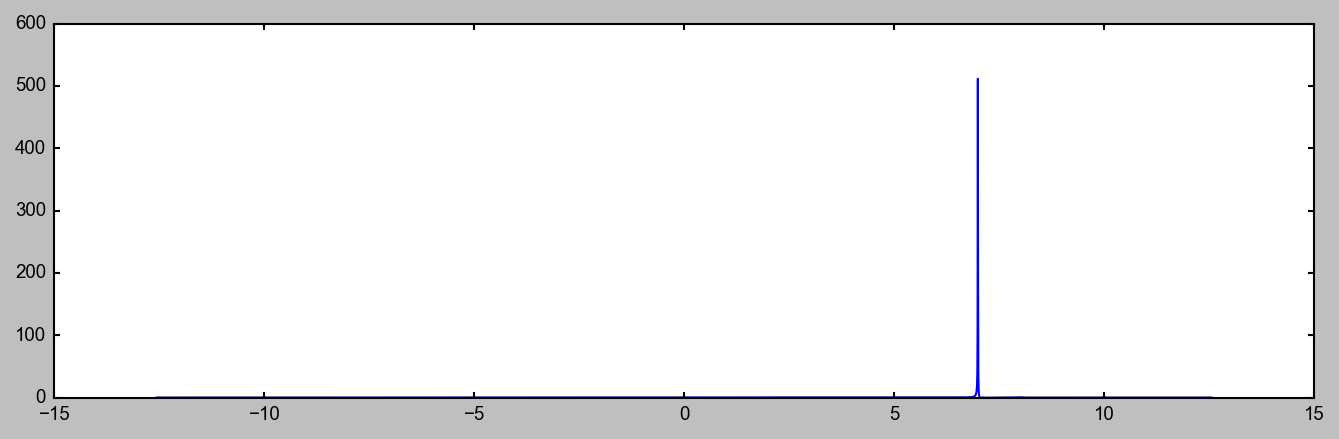

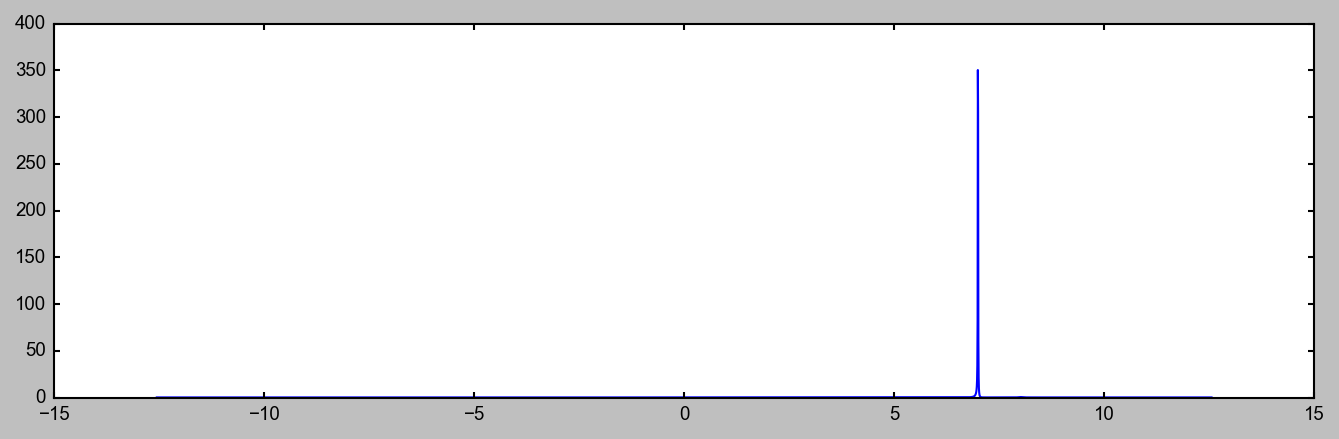

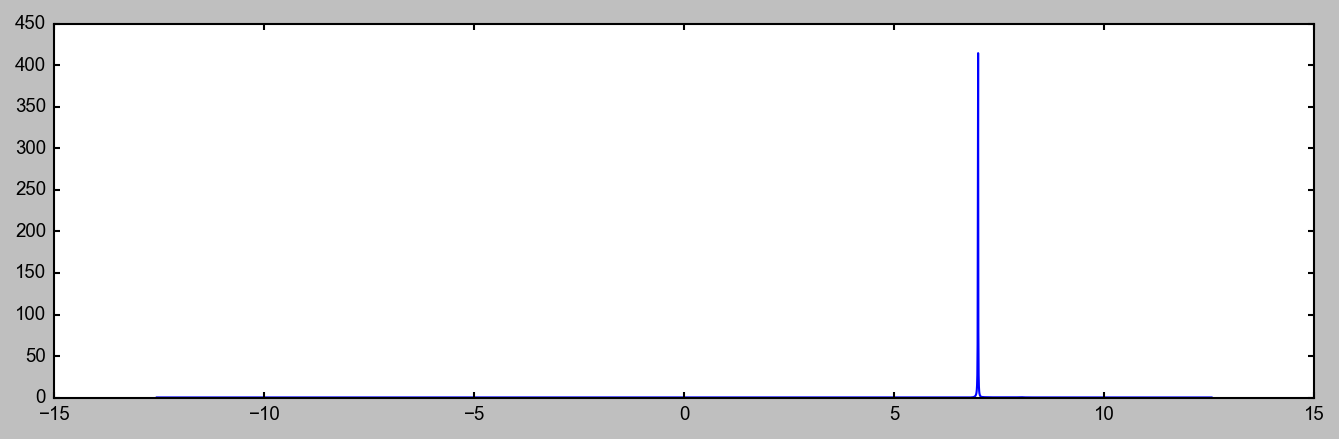

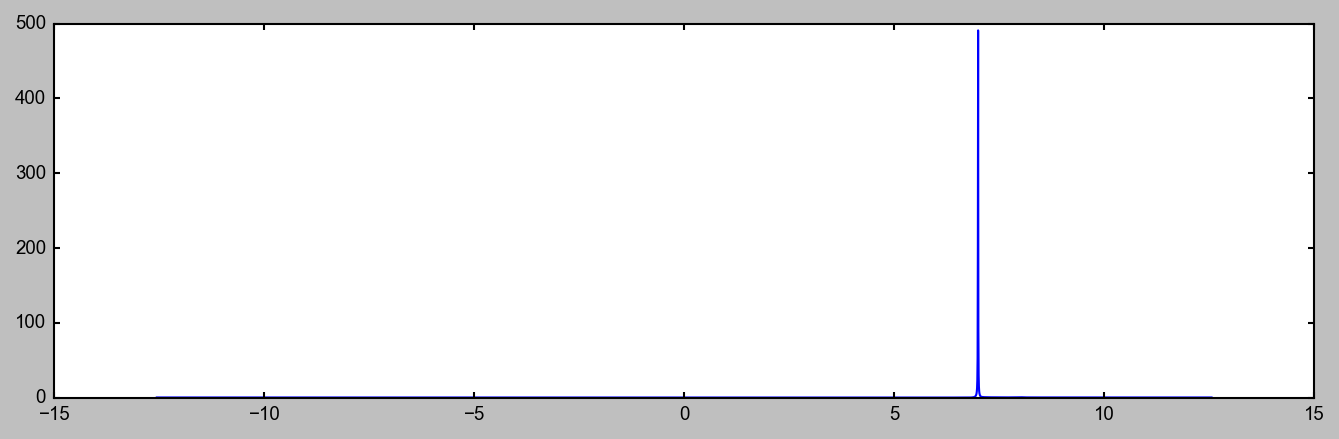

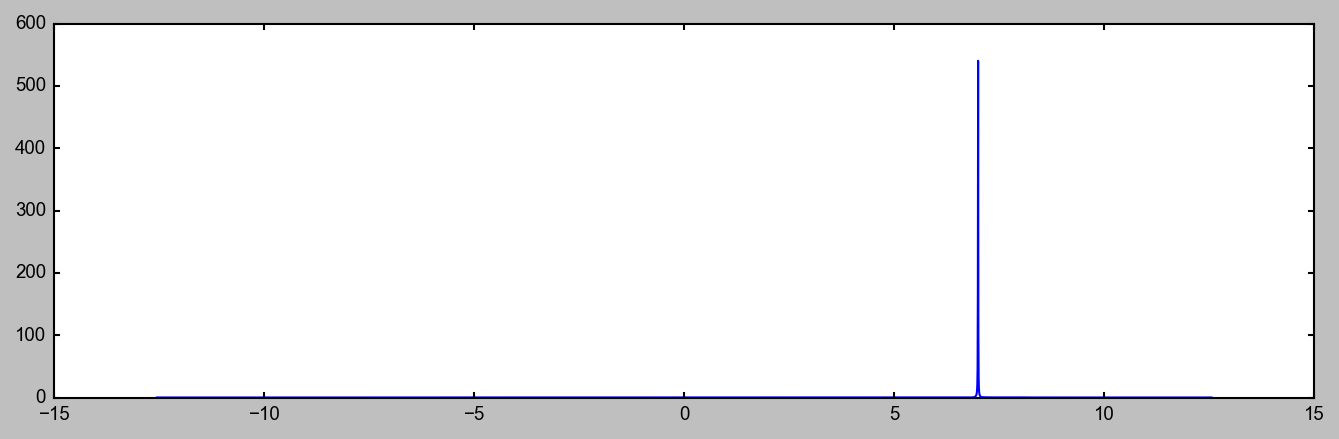

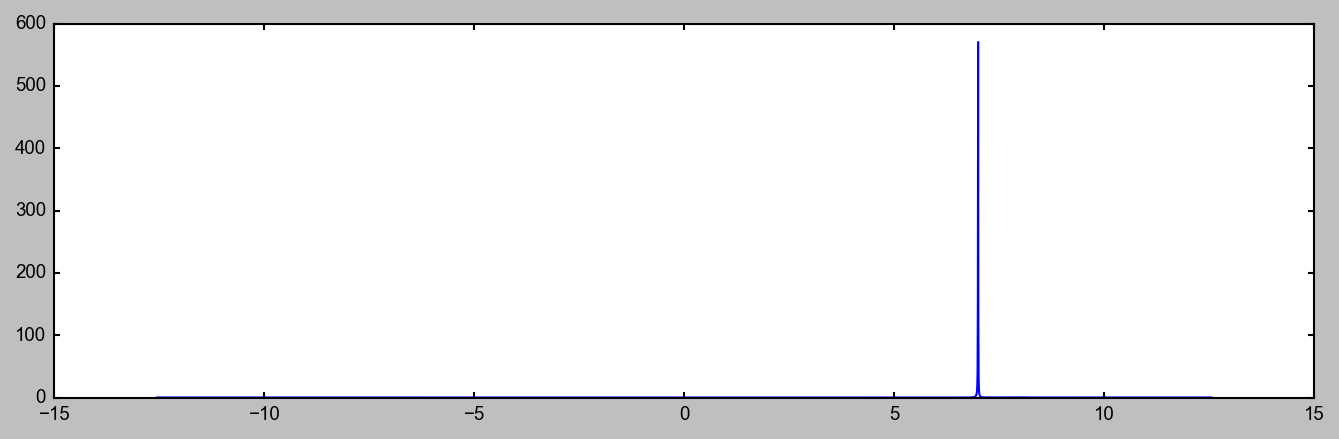

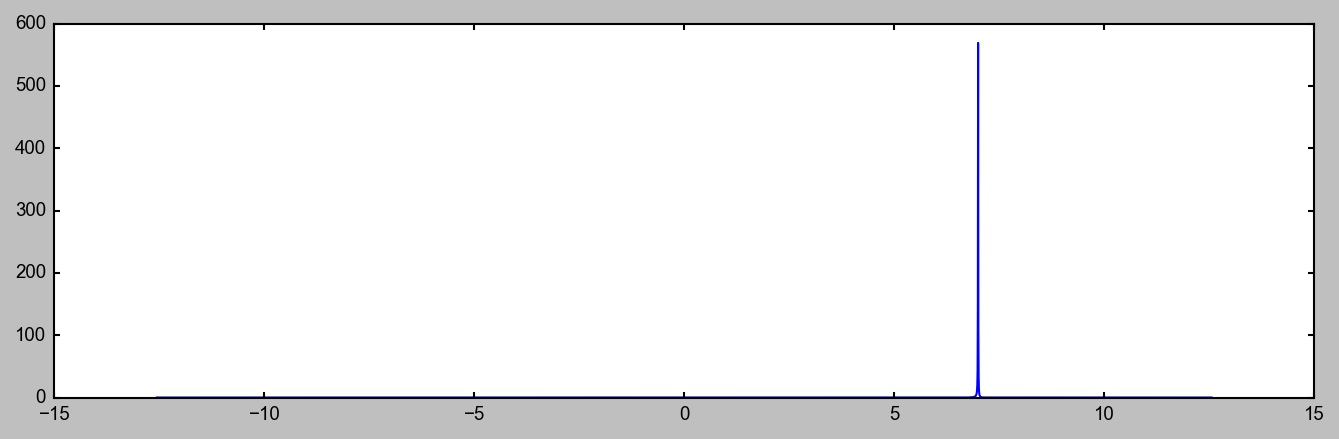

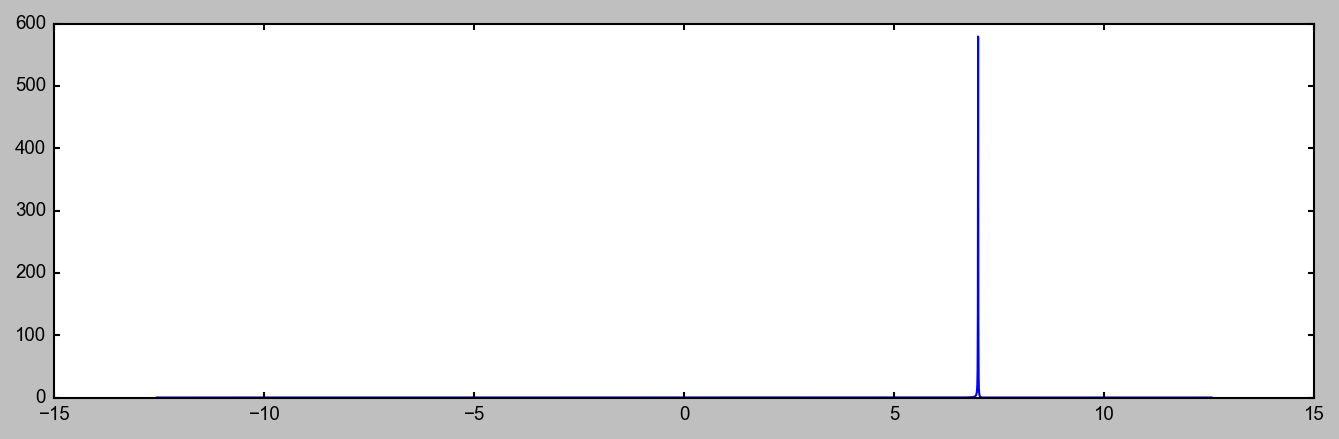

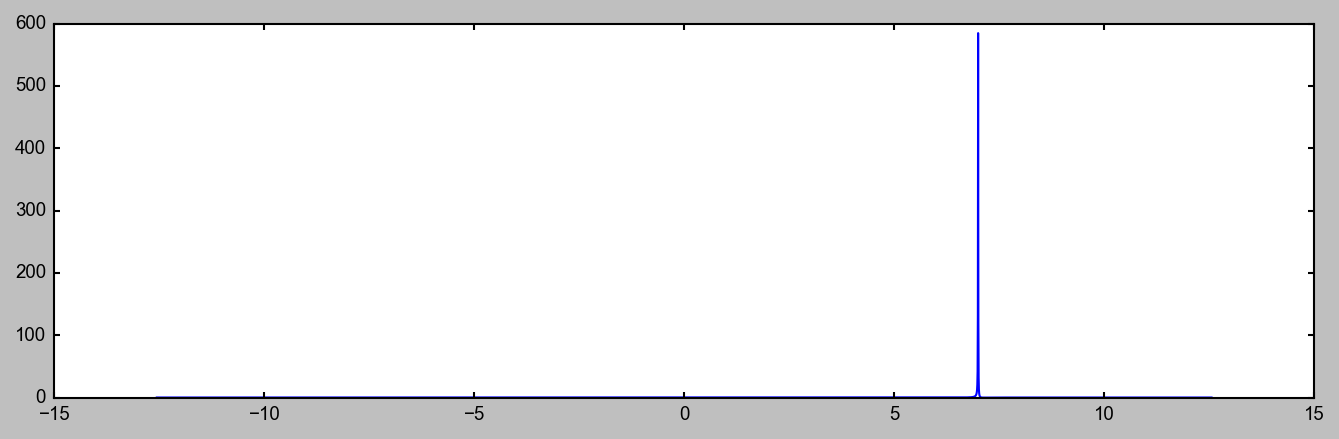

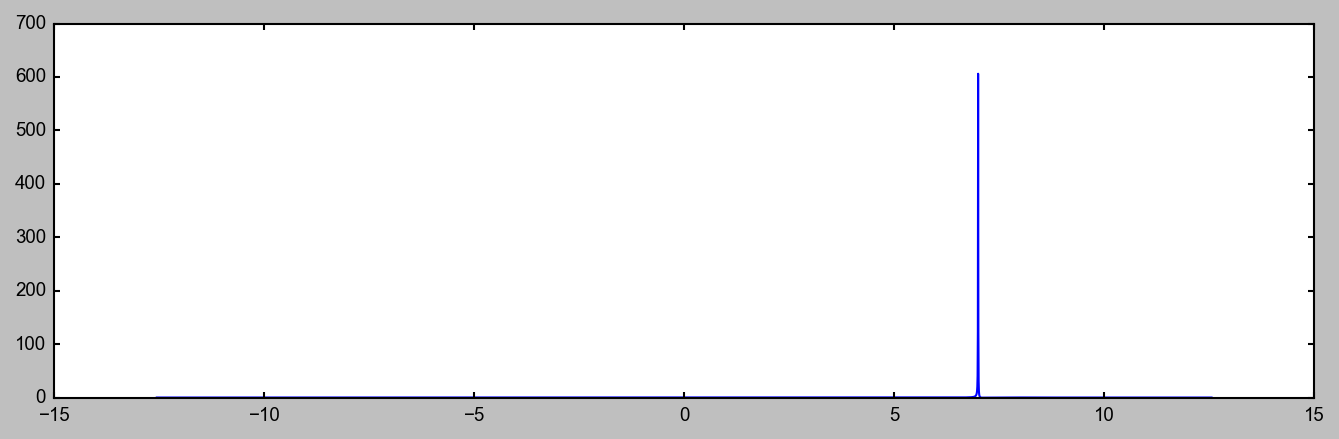

In [6]:
H_cav = fc * a.dag() * a
tlist = np.linspace(0, 1000, 4000)
psi0 = tensor(basis(N, 1), basis(2,0))
nth_as = np.linspace(0, 2, 11)
Ws = []
spectrums = []

for n in nth_as:
    c_ops = []
#
    # cavity relaxation
    rate = kappa * (1 + 0)
    if rate > 0.0:
        c_ops.append(sqrt(rate) * a)
    #
    # cavity excitation, if temperature > 0
    rate = kappa * 0
    if rate > 0.0:
        c_ops.append(sqrt(rate) * a.dag())
    #
    # qubit relaxation
    rate = gamma * (1+n)
    if rate > 0.0:
        c_ops.append(sqrt(rate) * sm)
        
    rate = gamma * n
    if rate > 0.0:
        c_ops.append(sqrt(rate) * sm.dag())

    #psi0 = tensor(coherent(N, n), (basis(2,0)+basis(2,1)).unit())
    corr_vec = correlation_2op_1t(H, psi0, tlist, c_ops, a.dag(), a)
    w, S = spectrum_correlation_fft(tlist, corr_vec)
    
    fig, ax = plt.subplots(figsize=(9,3))
    ax.plot(w, abs(S))

    Ws.append(w)
    spectrums.append(abs(S))
Ws = np.array(Ws)
spectrums = np.array(spectrums)

In [50]:
np.exp(-1)

0.36787944117144233

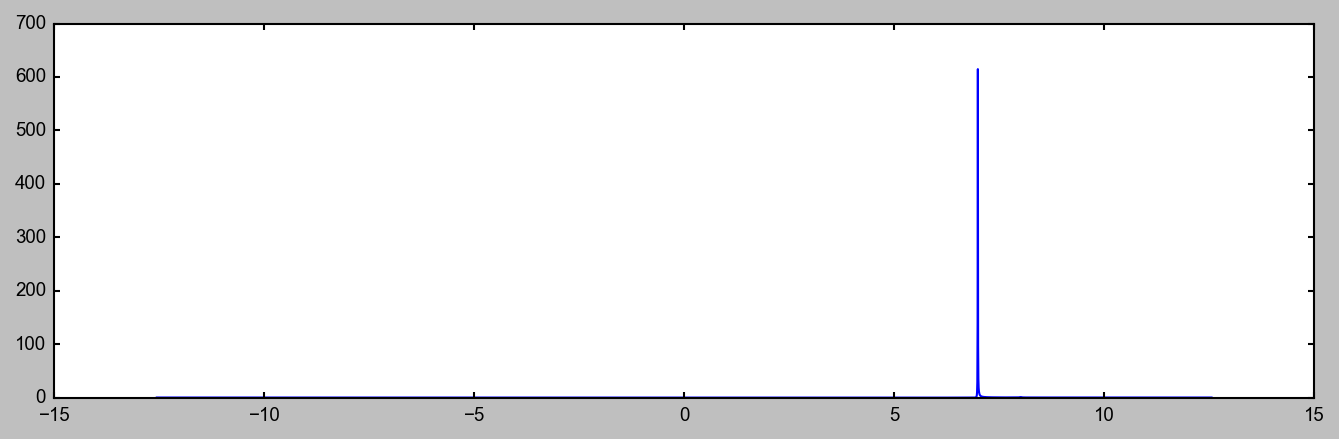

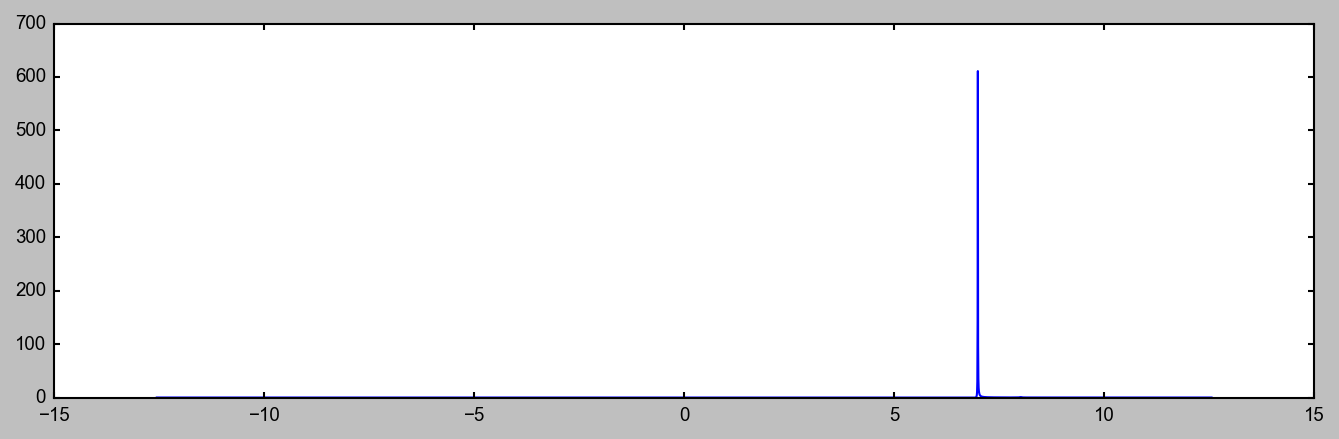

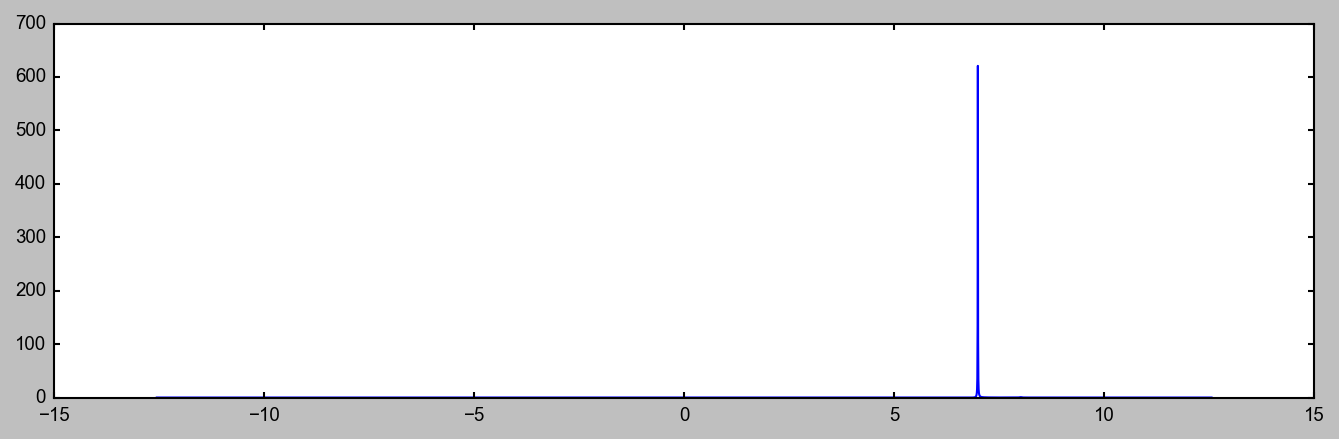

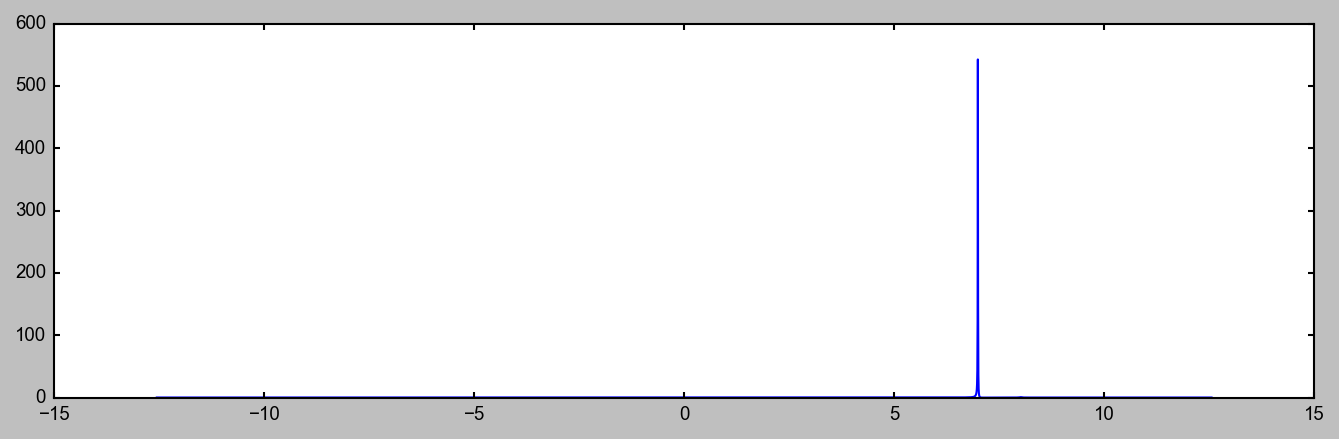

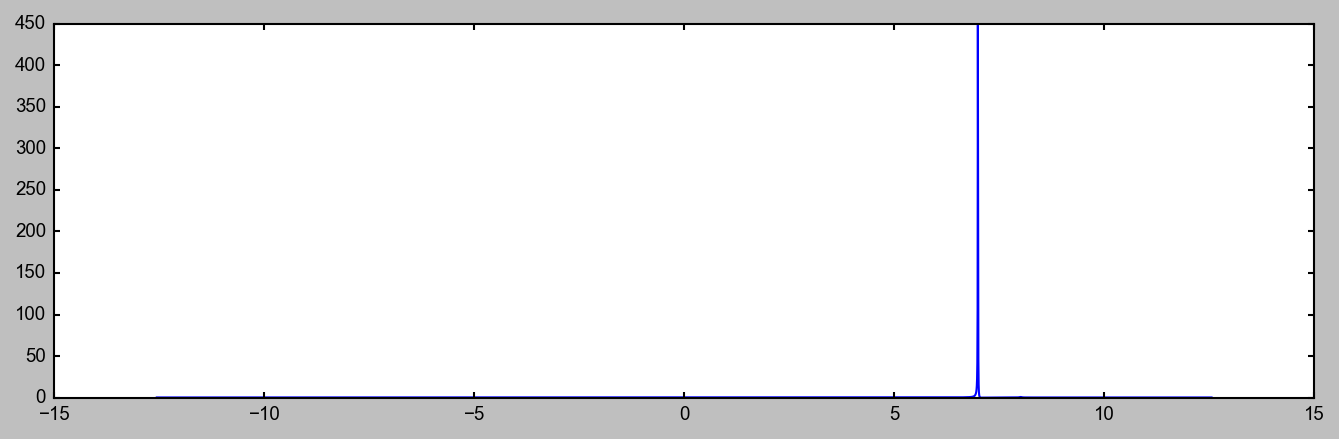

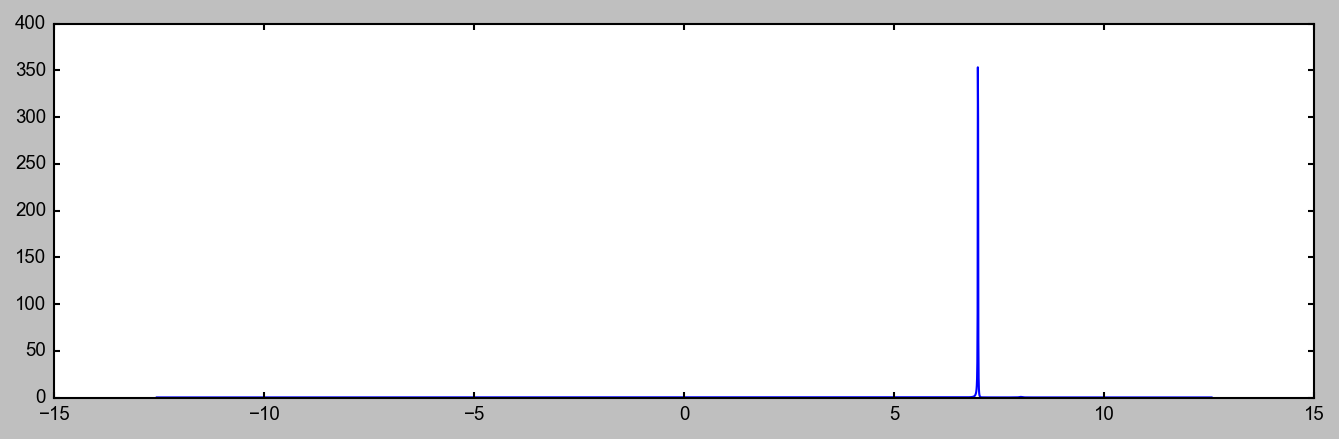

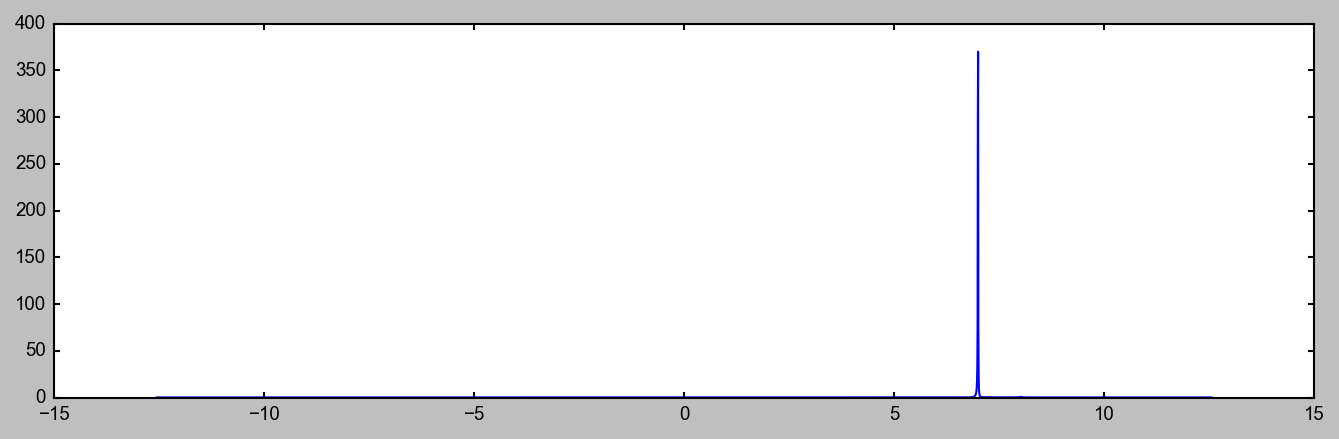

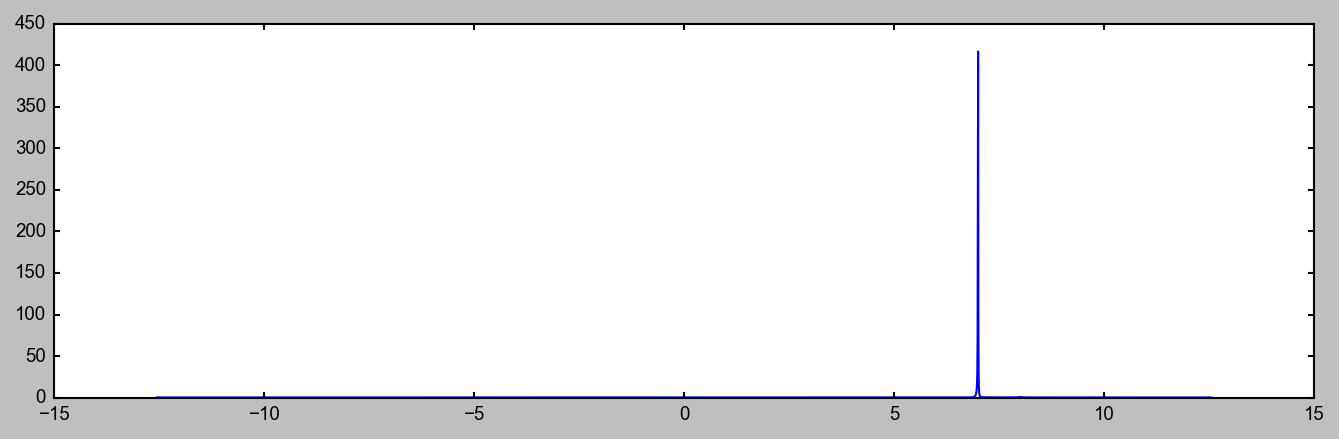

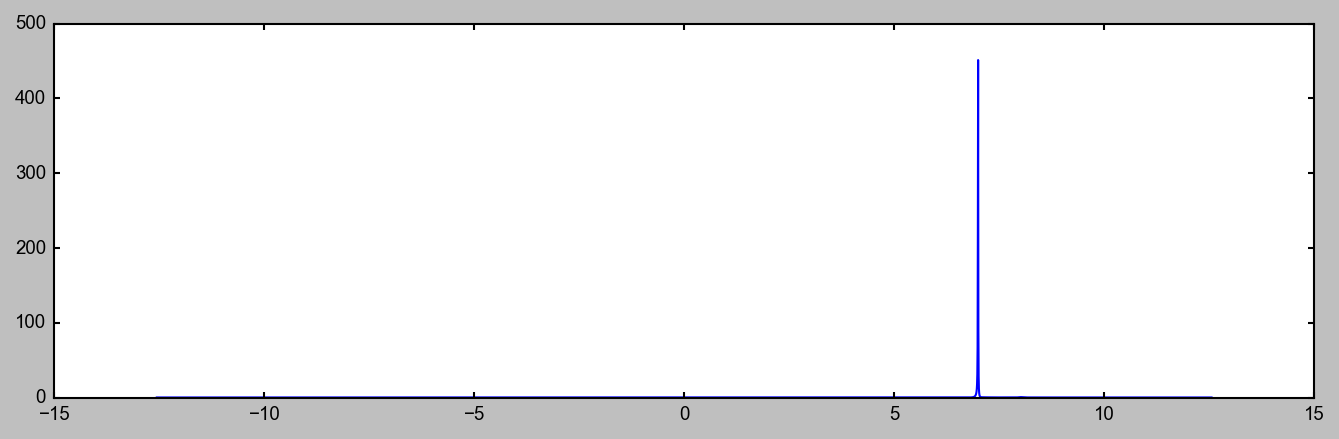

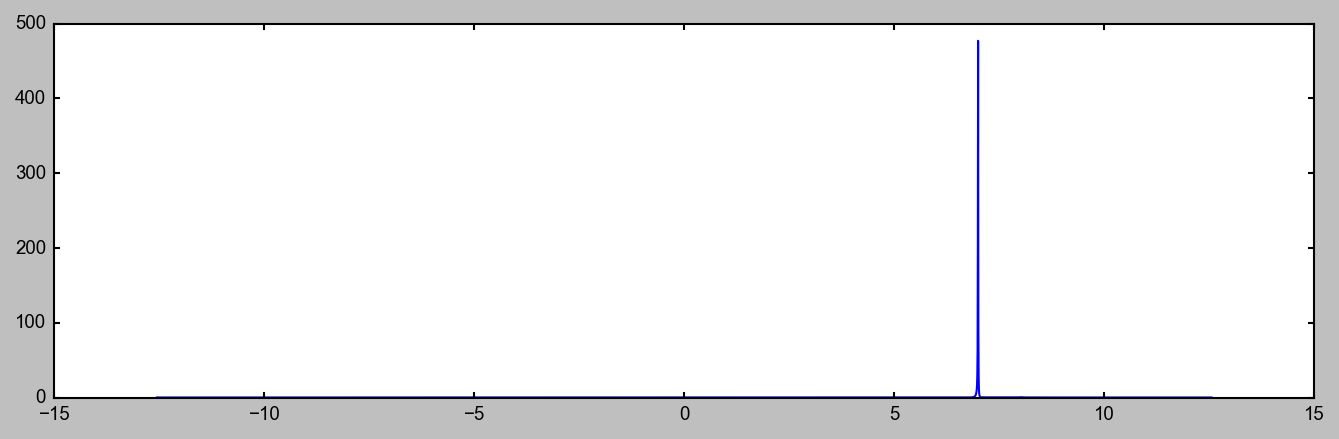

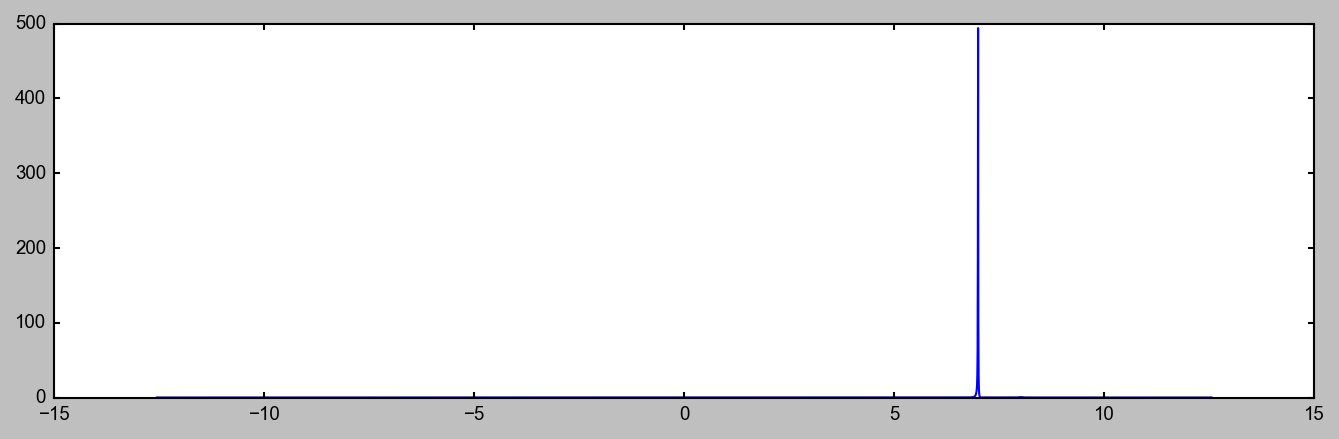

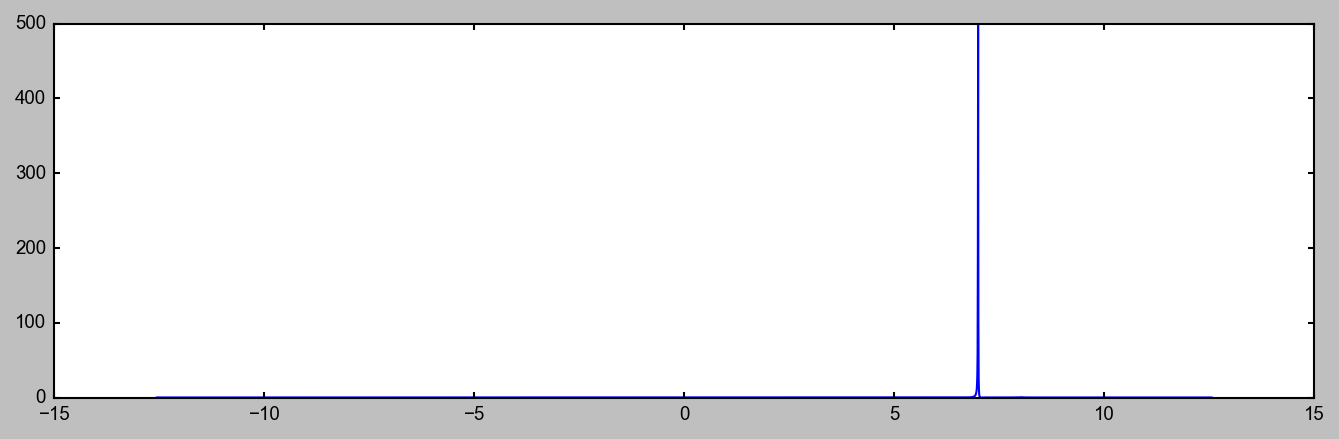

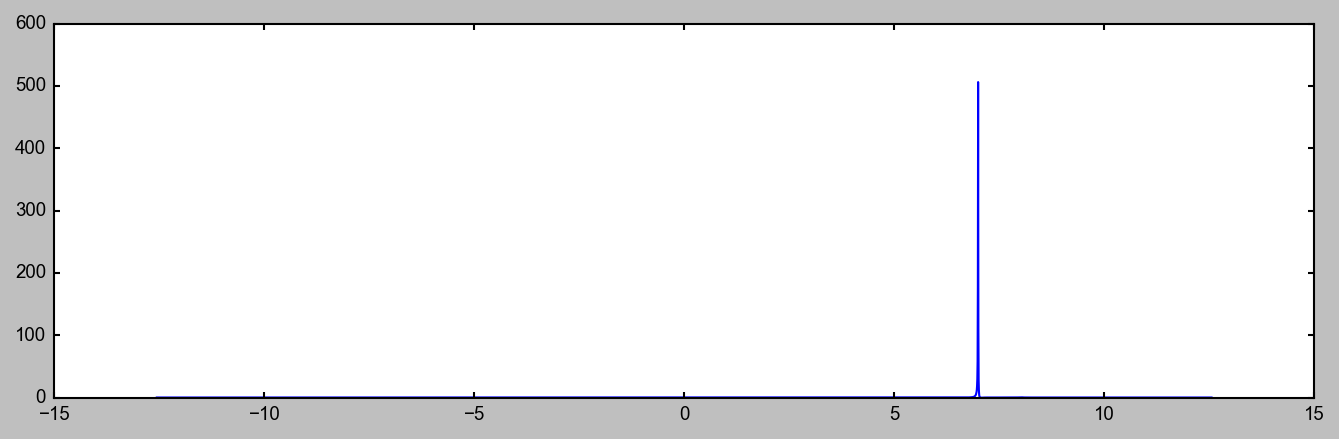

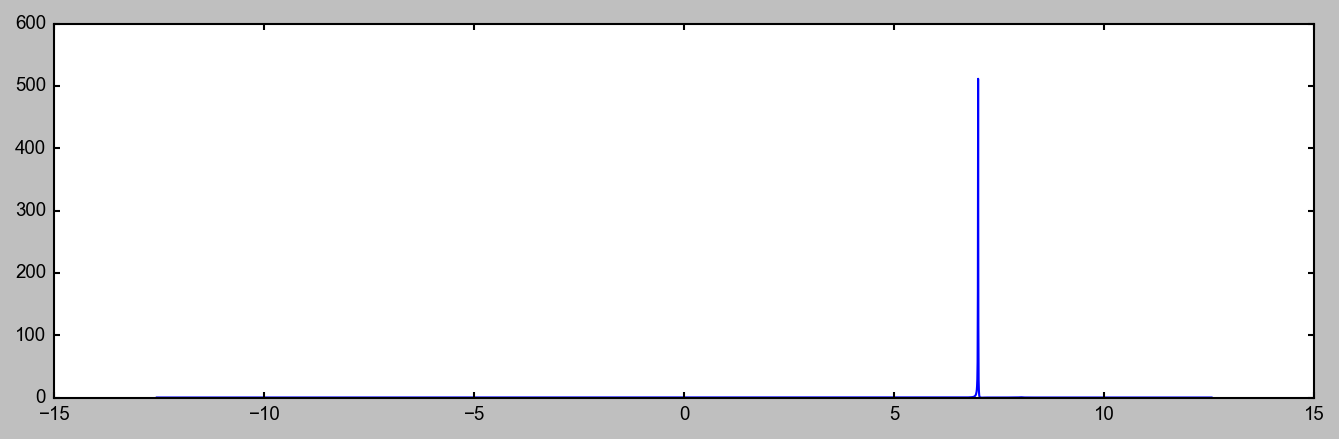

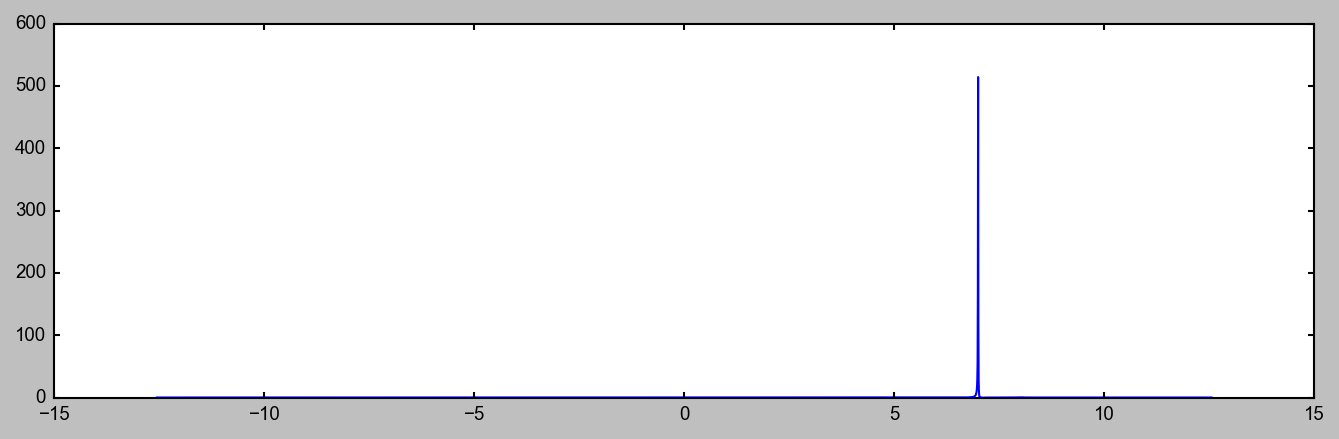

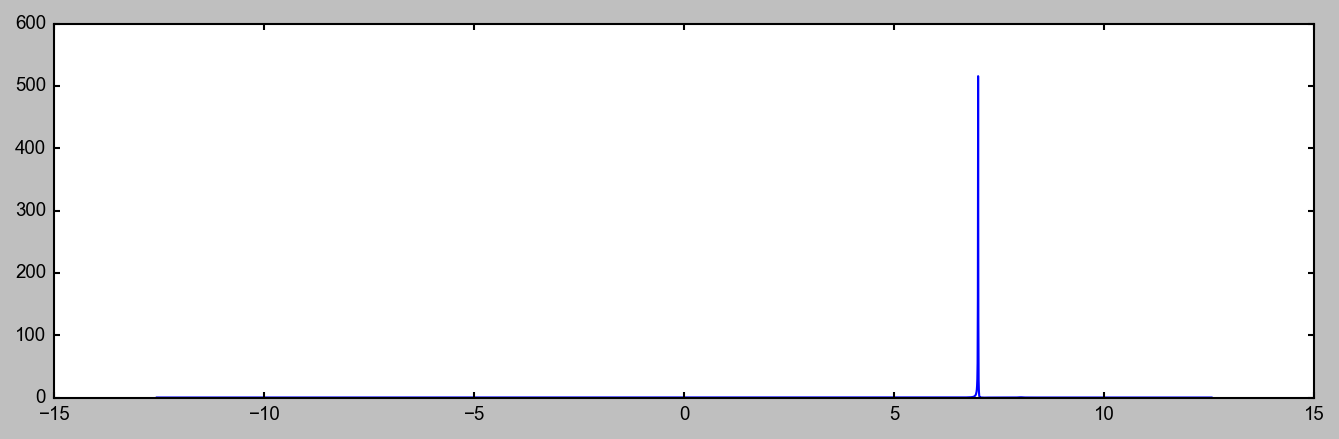

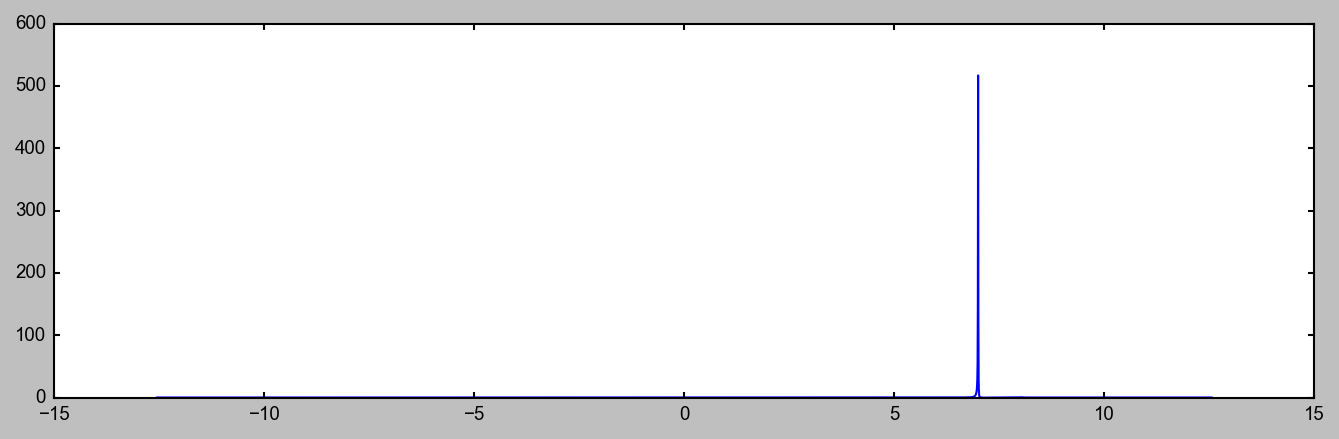

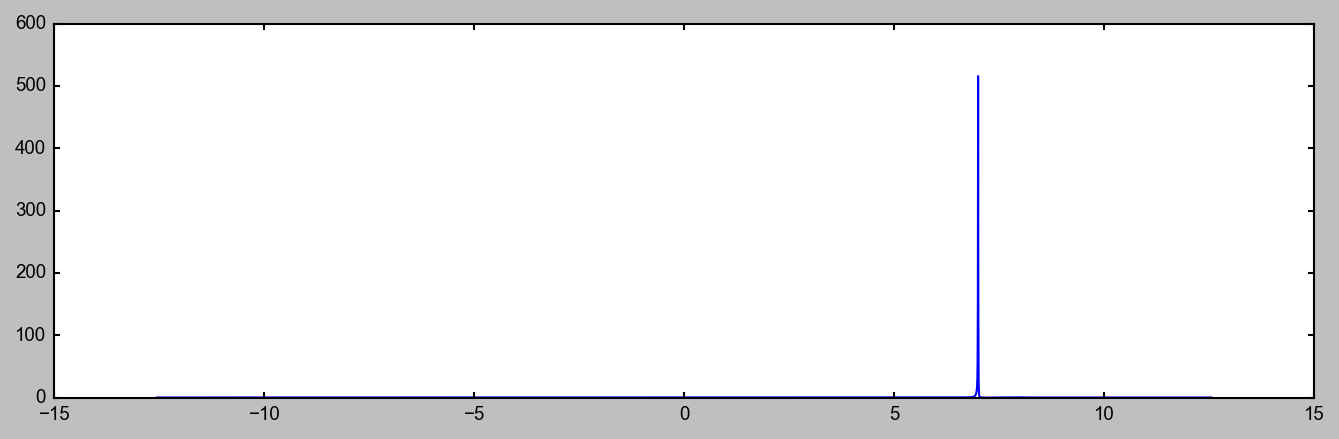

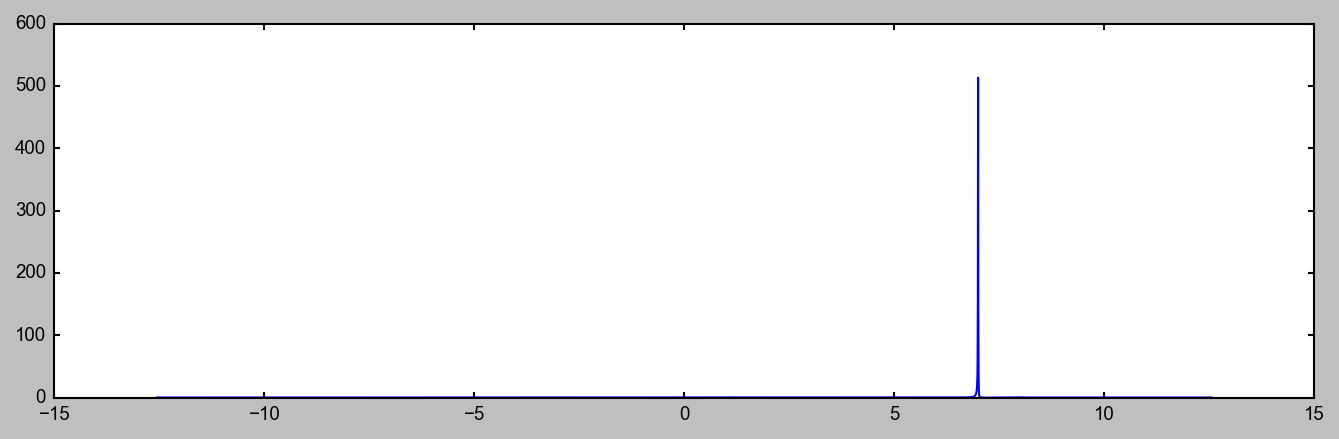

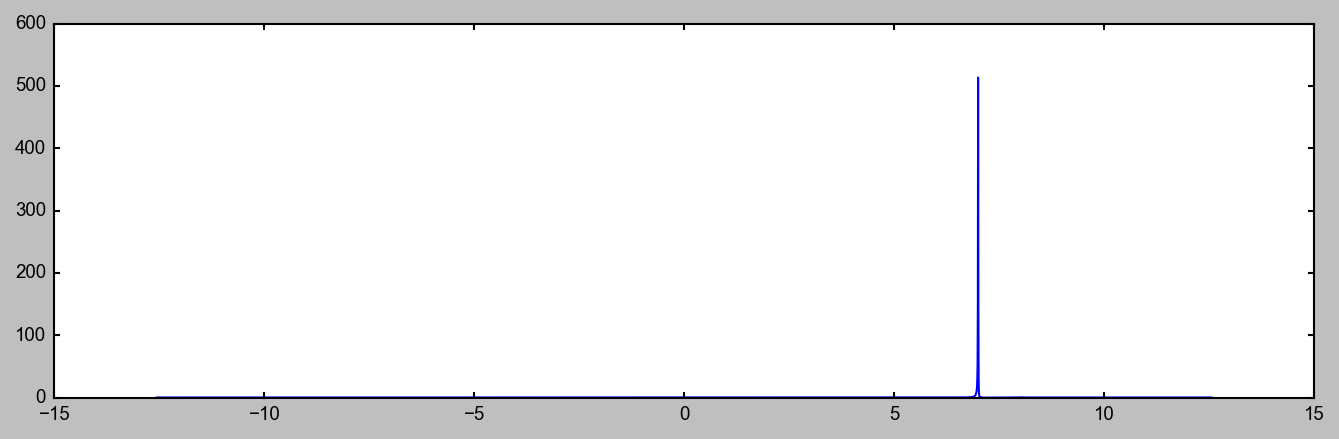

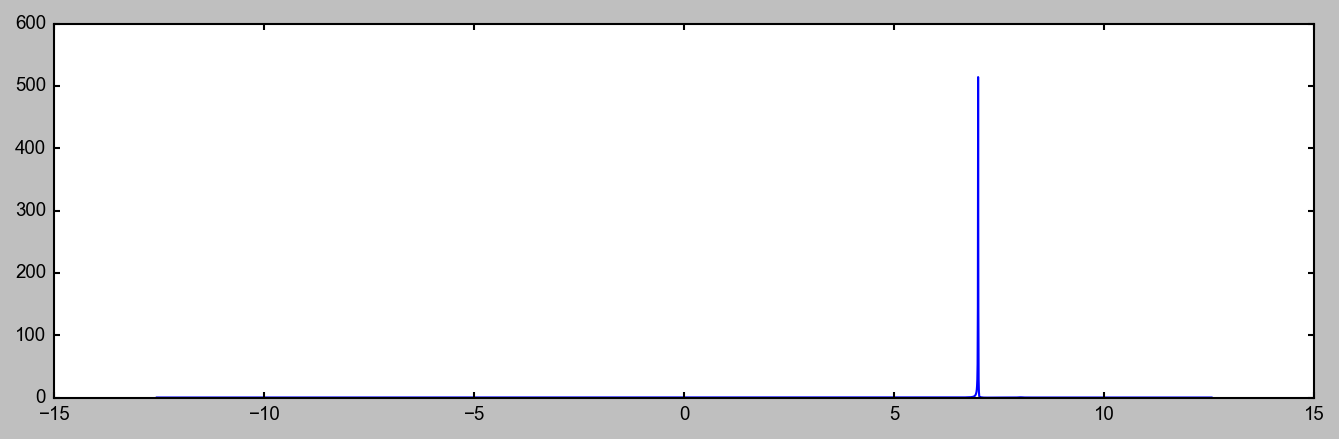

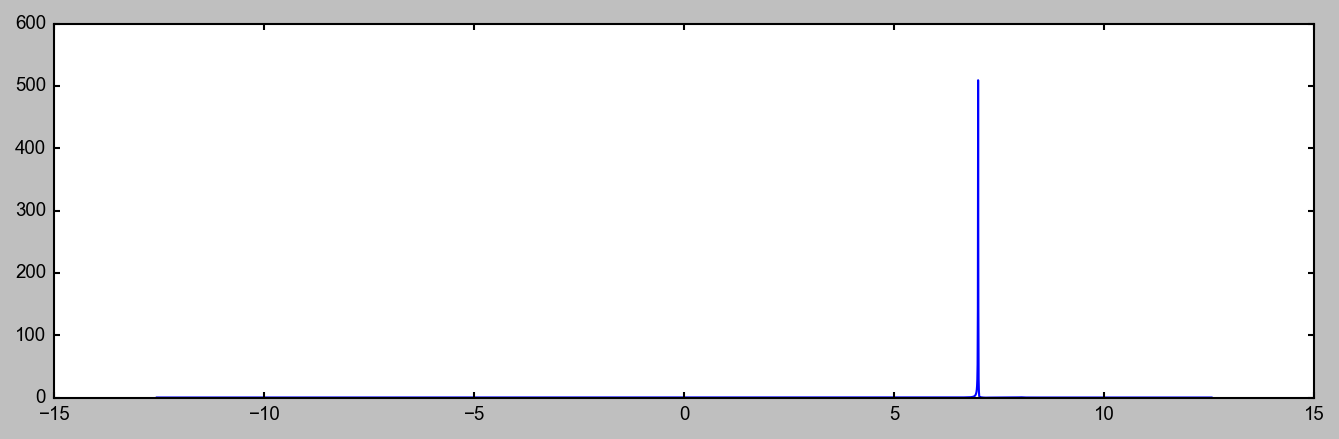

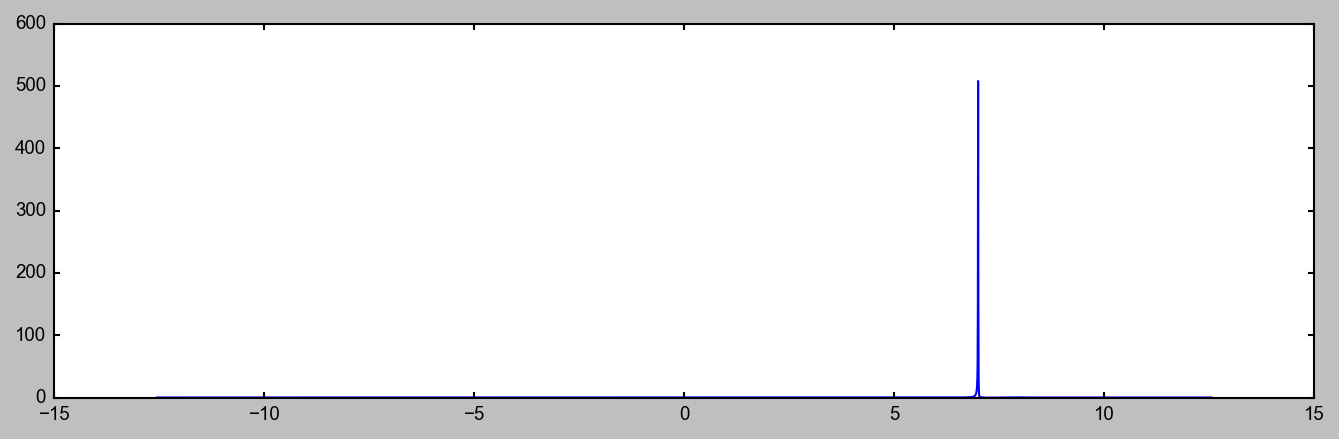

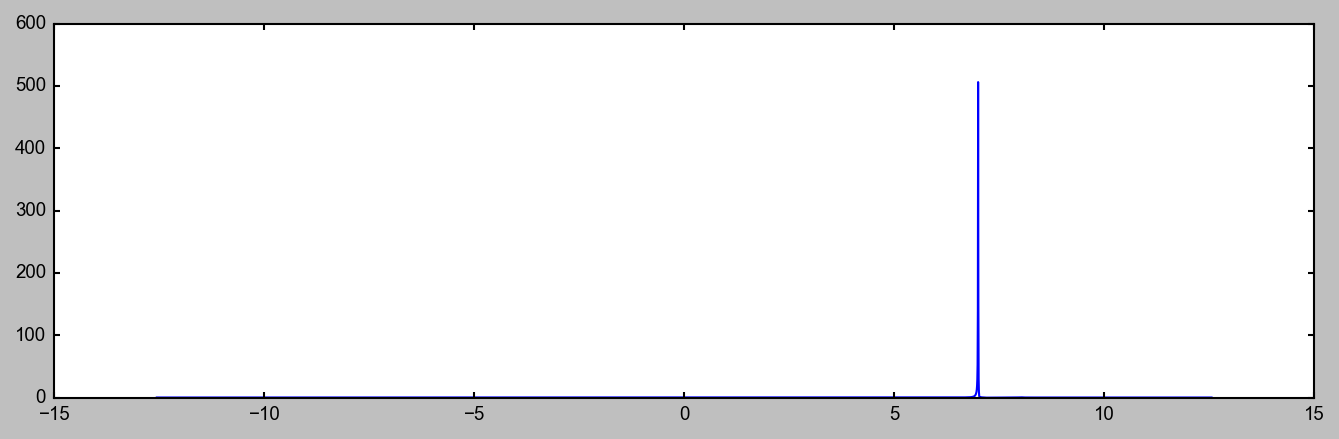

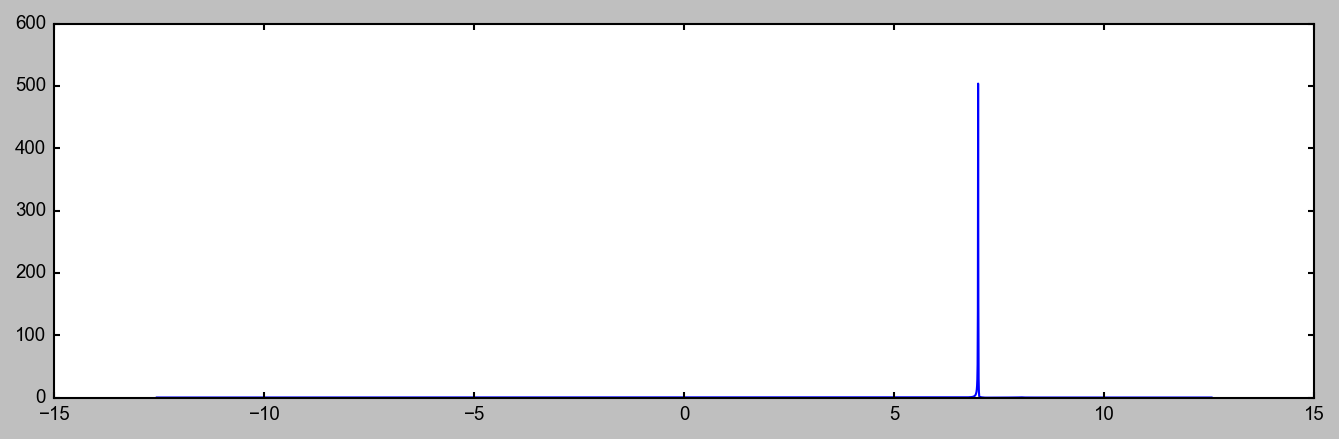

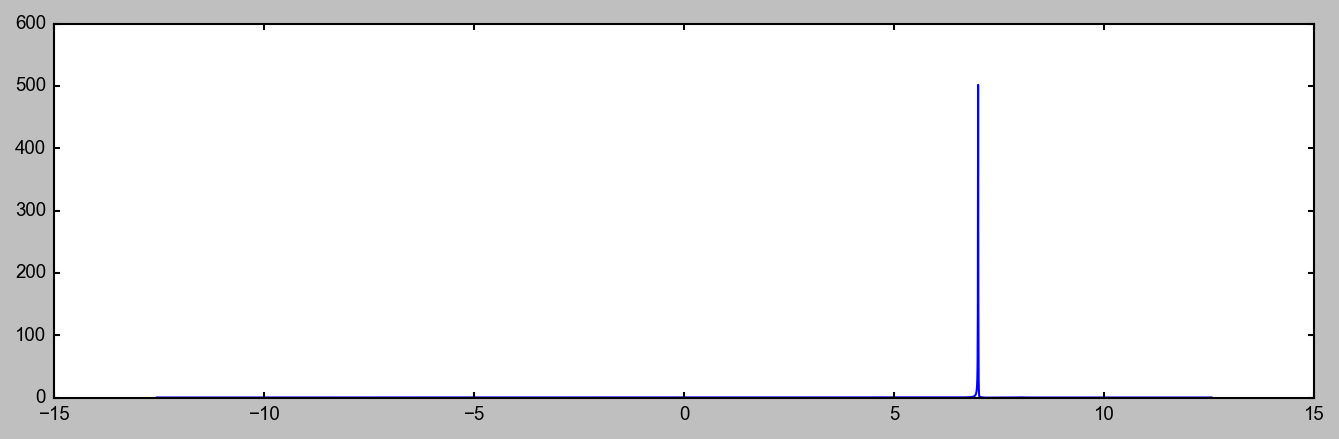

In [7]:
H_cav = fc * a.dag() * a
tlist = np.linspace(0, 1000, 4000)
psi0 = tensor(basis(N, 1), basis(2,0))
rates = np.linspace(0, 4, 26)
Ws = []
spectrums = []

for r in rates:
    c_ops = []
#
    # cavity relaxation
    rate = kappa * (1 + r)
    if rate > 0.0:
        c_ops.append(sqrt(rate) * a)
    #
    # cavity excitation, if temperature > 0
    rate = kappa * r
    if rate > 0.0:
        c_ops.append(sqrt(rate) * a.dag())
    #
    # qubit relaxation
    rate = gamma
    if rate > 0.0:
        c_ops.append(sqrt(rate) * sm)
        
    rate = gamma * np.exp(-1/r)
    if rate > 0.0:
        c_ops.append(sqrt(rate) * sm.dag())

    #psi0 = tensor(coherent(N, n), (basis(2,0)+basis(2,1)).unit())
    corr_vec = correlation_2op_1t(H, psi0, tlist, c_ops, a.dag(), a)
    w, S = spectrum_correlation_fft(tlist, corr_vec)
    
    fig, ax = plt.subplots(figsize=(9,3))
    ax.plot(w, abs(S))

    Ws.append(w)
    spectrums.append(abs(S))
Ws = np.array(Ws)
spectrums = np.array(spectrums)

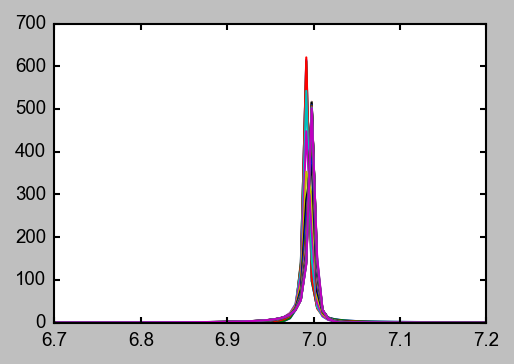

In [7]:
fig, ax = plt.subplots()
Ws = np.array(Ws)
spectrums = np.array(spectrums)
fr = []
Ql = []

for i in range(len(Ws)):
    mask = np.logical_and(Ws[i]>6.7, Ws[i]<7.2)
    ax.plot(Ws[i][mask], spectrums[i][mask])
    popt, error = fit_skewed_lorentzian(Ws[i][mask], spectrums[i][mask])
    fr.append(popt[4])
    Ql.append(popt[5])


#ax.plot(nth_as, fr, '*')

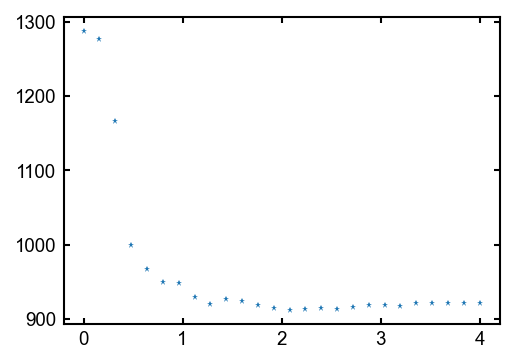

In [152]:
plt.plot(rates, Ql, '*')

In [6]:
plt.style.use('genstyle')

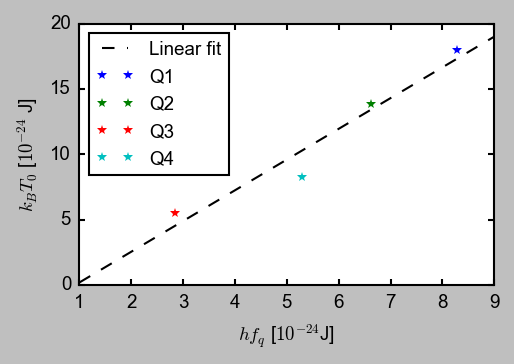

In [12]:
from scipy.constants import k, h, mu_0, e, Boltzmann



fq = [12.5,10,4.3, 8]
Ts = [1.3,1, 0.4,0.6]
fig,ax = plt.subplots()

fit = np.polyfit(h*np.array(fq)*1e9*1e24, k*np.array(Ts)*1e24, deg=1)
func = np.poly1d(fit)
ax.plot(np.linspace(1,9,9), func(np.linspace(1,9,9)), 'k--', label='Linear fit')

for i in range(len(fq)):
    ax.plot(h*fq[i]*1e9*1e24,k*Ts[i]*1e24, '*', ms=5, label='Q{}'.format(i+1))
ax.set_xlabel(r'$hf_q$ [$10^{-24}$J]')
ax.set_ylabel(r'$k_B$$T_0$ [$10^{-24}$ J]')

#ax.set_ylim(ymin=0.3, ymax=1.5)



ax.legend(loc='upper left')

fig.savefig('chi_fq_T_correlation_renormed.pdf')

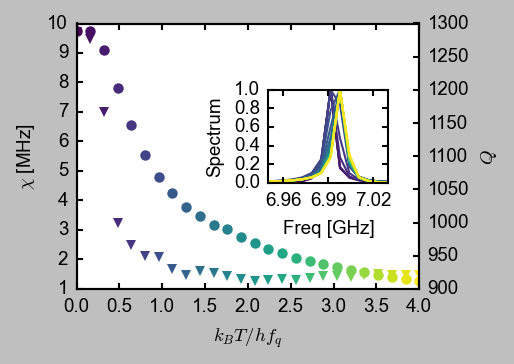

In [9]:
from matplotlib import cm

n_points = 26
#cmap = mpl.colors.Colormap('viridis')

colors = [cm.viridis(x) for x in np.linspace(0,1,n_points)]

fig, ax = plt.subplots()
ax2 = ax.twinx()
Ws = np.array(Ws)
spectrums = np.array(spectrums)
fr = []
Ql = []
axins = ax.inset_axes([0.56,0.4,0.35,0.35])

for i in range(len(Ws)):
    mask = np.logical_and(Ws[i]>6.7, Ws[i]<7.2)
    axins.plot(Ws[i][mask], spectrums[i][mask]/max(spectrums[i][mask]), color=colors[i])
    popt, error = fit_skewed_lorentzian(Ws[i][mask], spectrums[i][mask])
    fr.append(popt[4])
    Ql.append(popt[5])
    axins.set_xlim(xmin=6.95, xmax=7.03)
    axins.xaxis.set_major_locator(MaxNLocator(nbins=4))
    ax.plot(rates[i], (7-popt[4])*1e3, 'o', ms=5, color=colors[i])
    ax2.plot(rates[i], popt[5], 'v', ms=5, color=colors[i])

axins.set_xlabel('Freq [GHz]')
axins.set_ylabel('Spectrum')
ax.set_xlabel(r'$k_B T / h f_q$')
ax.set_ylabel(r'$\chi$ [MHz]')
ax2.set_ylabel(r'$Q$')
fig.savefig('qubit_cav_simul.pdf')

# Varying Qubit Excitation Rate

In [25]:
tlist = np.linspace(0, 1000, 2160)
psi0 = tensor(fock_dm(2*N+1, 1), ket2dm((basis(2*N+1,0))).unit())
w, spectrum = system1.cavity_spectrum(tlist, psi0, plot=True)

Exception: ODE integration error: Try to increase the allowed number of substeps by increasing the nsteps parameter in the Options class.

In [24]:
ws, spectrums = [], []
for gamma in gammas:

    for nth_q in nth_qs:
    system1.update_Htot(nth_q=nth_q)
    psi0 = tensor(fock_dm(2*N+1, 1), thermal_dm(2*N+1, nth_q).unit())
    w, spectrum = system1.cavity_spectrum(tlist, psi0, plot=True)
    with open(folder+'Ej50_coponly_0to1_ws.csv','a') as f:
        writer = csv.writer(f)
        writer.writerow(w)
    with open(folder+'Ej50_coponly_0to1_specs.csv','a') as f:
        writer = csv.writer(f)
        writer.writerow(spectrum)

    psi1 = tensor(thermal_dm(2*N+1, nth_q).unit(),  thermal_dm(2*N+1, nth_q).unit())
    w, spectrum = system1.cavity_spectrum(tlist, psi1, plot=True)
    with open(folder+'Ej50_boththermalstate_0to1_ws.csv','a') as f:
        writer = csv.writer(f)
        writer.writerow(w)
    with open(folder+'Ej50_boththermalstate_0to1_specs.csv','a') as f:
        writer = csv.writer(f)
        writer.writerow(spectrum)
    system1.update_Htot(gamma=gamma)
    psi0 = tensor(basis(2*N+1, 1), basis(2*N+1,0))
    w, spectrum = system1.cavity_spectrum(tlist, psi0, plot=True)
    ws.append(w)
    spectrums.append(spectrum)

Exception: ODE integration error: Try to increase the allowed number of substeps by increasing the nsteps parameter in the Options class.